<a href="https://colab.research.google.com/github/TadieB/pytorch-collab/blob/main/DeepNN_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [2]:
# if imports fail, uncomment and run the commands below

# !conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet

In [4]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline


# Download The Data

In [5]:
dataset = MNIST(root = 'data/',
                download =True,
                transform=ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 137298757.13it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 31341706.03it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 84339110.46it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4634037.65it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Splitting the Dataset

In [6]:
val_size = 10000
train_size = len(dataset)-val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds),len(val_ds)

(50000, 10000)

In [7]:
batch_size = 128

In [10]:
train_loader = DataLoader(train_ds,batch_size, shuffle=True,num_workers=2,pin_memory=True)
val_loader = DataLoader(val_ds,batch_size*2, shuffle=True,num_workers=2,pin_memory=True)

In [12]:
for images, _ in train_loader:
  print('images.shape',images.shape)
  break

images.shape torch.Size([128, 1, 28, 28])


images.shape torch.Size([128, 1, 28, 28])


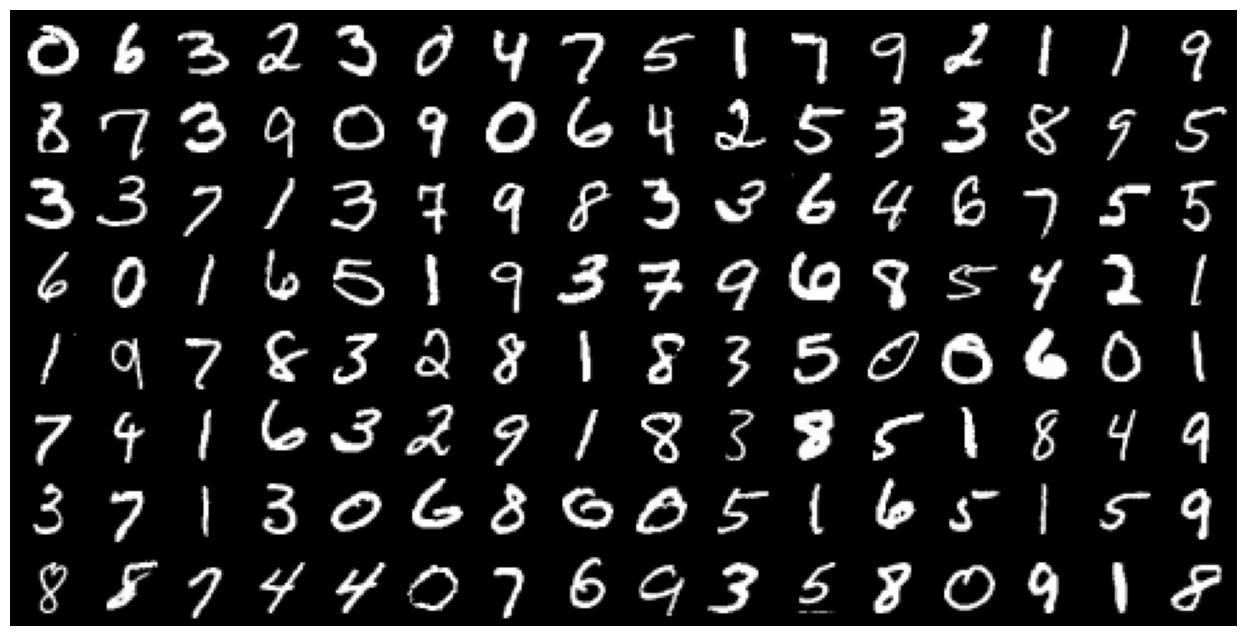

In [13]:
for images, _ in train_loader:
  print('images.shape',images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images,nrow=16).permute((1,2,0)))
  break

# Model

+ each of nn.Layer object is caalled a layer in the nn.
+ input layer batch_size x 784, input matrix.
+ first layer(hidden layer) batch_size x hidden_size. hidden_size preconfigued parameter e.g 32, 64 or ...
+ Then passed to non-linear activation function,
+ the result of  activation batch_size x hidden_size, is passed into 2nd layer, output layer which transforms it into
+ a matrix of size batch_size x 10,
+ one hidden layer can introduce: complexity, non-linear relationship b/n inputs &targes

In [ ]:
def model(xb):
  return xb @ w.t()+b

# init
# self.linear1 = nn.Linear(28*28,16)
# self.linear2 = nn.Linear(16,10)

# forward():
#   out = self.linear1(xb)
#   out = F.relu(out)
#   out = self.linear2(out)
#   return out

# out = (xb @ w1 + b1) @ w2 + b2 = xb @ ((w1 @ W2)+(b1@w1) )+b2 =  xb @ w3 + b2= self.liner3(xb)

In [14]:
def accuracy(outputs, labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [15]:
class MnistModel(nn.Module):
  ''' Feedforward neual network with 1 hidden layer'''
  def __init__(self,in_size, hidden_size, out_size):
    super().__init__()
    # hidden layer
    self.linear1 = nn.Linear(in_size,hidden_size)
    # output layer
    self.linear2 = nn.Linear(hidden_size,out_size)

  def forward(self, xb):
    # Flatten the image tensors
    xb = xb.view(xb.size(0),-1) #size(0), 0 is first dimension or batch size
    # Get intermediate outputs using hidden layer
    out = self.linear1(xb)
    # Apply activation function
    out = F.relu(out)
    # Get pedictions using output layer
    out = self.linear2(out)
    return out

  def training_step(self, batch):
    images,labels = batch
    out = self(images) # Generate predictions
    loss = F.cross_entropy(out, labels) # calculate loss
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images) # Generate predictions
    loss = F.cross_entropy(out,labels)#calculate loss
    acc = accuracy(out, labels) # calculate accuracy
    return {'val_loss':loss,'val_acc':acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() # combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean() #combine accuracies
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self,epoch,result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['val_loss'],result['val_acc']))


In [16]:
input_size = 784
hidden_size = 32 # can be 64 or ...
num_classes = 10


In [17]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [19]:
model

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [18]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


# Try the Model with Only the First Batch

+ 128 images

In [20]:
for images, labels in train_loader:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('Loss:', loss.item())
  break

print('outputs.shape:',outputs.shape)
print('Sample.outputs:',outputs[:2].data)

# train_loader shuffel, and split images/traing sets in batches
# for loop first pass is first batch, 2nd pass 2nd batch
# so if there is break only first batch is done.

Loss: 2.3110945224761963
outputs.shape: torch.Size([128, 10])
Sample.outputs: tensor([[-0.1473, -0.1354,  0.0828,  0.2005, -0.1449, -0.0046,  0.1504, -0.1242,
          0.0142, -0.1355],
        [-0.1550, -0.1219,  0.0665,  0.1161,  0.0182,  0.0096,  0.1682, -0.1712,
          0.0899, -0.2402]])


# Using a GPU

In [21]:
# CHECK IF A gpu is available and the required NVIDIA CUDA dives ae installed

torch.cuda.is_available()

False

+ If GPU available, use GPUT. Otherwise, use defaults (CPU)

In [23]:
def get_default_device():
  '''Pick GPU if available, else CPU'''
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [24]:
device = get_default_device()
device

device(type='cpu')

+ Move Data and Model to a Chosen Device

In [27]:
def to_device(data, device):
  '''Move tensor(s) to chosen device'''
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking=True)

# This function takes data (a tensor or a list/tuple of tensors) and device as input.
# If data is a list or tuple, it recursively applies to_device to each element of the container.
# If data is a tensor, it moves the tensor to the specified device using data.to(device, non_blocking=True).
# The non_blocking=True argument in to_device() makes the data transfer asynchronous,

In [30]:
for images, labels in train_loader:
  print(images.shape)
  images = to_device(images, device)
  print(images.device)
 # print(images)
  break

torch.Size([128, 1, 28, 28])
cpu


+ Define a Class to Wrap our existing data loaders and move dat to selected device


In [31]:
class DeviceDataLoader():
  ''' wrap a dataloader to move data to a device'''
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    '''Yield a batch of data after moving it to device'''
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    '''Number of batches'''
    return len(self.dl)

In [32]:
train_loader = DeviceDataLoader(train_loader,device)
val_loader = DeviceDataLoader(val_loader,device)

+ Tensors that have been moved to the GPU'S RAM have a device property which includes the word 'cuda'.
+ Let's verify this by looking at a batch of data from valid_dl.

In [33]:
for xb, yb in val_loader:
  print('xb.Device:', xb.device)
  print('yb:',yb)
  break

xb.Device: cpu
yb: tensor([1, 3, 1, 1, 4, 5, 4, 3, 5, 0, 2, 6, 0, 2, 6, 0, 2, 7, 1, 3, 5, 0, 8, 8,
        0, 1, 9, 6, 5, 8, 6, 4, 0, 0, 7, 7, 5, 5, 6, 3, 6, 8, 8, 8, 4, 8, 3, 3,
        1, 7, 5, 5, 6, 4, 2, 2, 2, 7, 3, 1, 8, 2, 7, 8, 0, 7, 2, 1, 5, 0, 0, 8,
        2, 4, 1, 6, 3, 2, 5, 3, 6, 1, 7, 1, 6, 3, 0, 6, 0, 1, 9, 5, 3, 1, 6, 2,
        9, 0, 9, 9, 1, 6, 1, 1, 7, 6, 3, 4, 8, 2, 4, 0, 2, 2, 7, 4, 4, 8, 1, 8,
        5, 2, 2, 6, 2, 0, 5, 8, 4, 1, 2, 1, 6, 3, 3, 9, 5, 1, 1, 5, 6, 8, 8, 2,
        7, 9, 3, 1, 1, 4, 2, 4, 9, 6, 4, 0, 5, 1, 8, 0, 5, 9, 3, 9, 0, 6, 4, 8,
        5, 3, 3, 9, 5, 1, 3, 3, 2, 5, 2, 5, 7, 0, 5, 3, 3, 2, 8, 4, 4, 1, 1, 1,
        2, 3, 9, 9, 6, 8, 4, 1, 0, 9, 7, 9, 6, 2, 2, 3, 9, 1, 4, 1, 7, 3, 6, 0,
        7, 6, 1, 7, 3, 3, 0, 8, 6, 5, 8, 0, 0, 4, 1, 0, 0, 4, 8, 8, 3, 1, 9, 5,
        6, 4, 8, 5, 7, 1, 9, 2, 4, 7, 4, 5, 9, 0, 2, 5])


# Trining the **Model**

In [ ]:
def evaluate(model,val_loader):
